In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

# Aufgabe 9: Implementierung eines gedämpften Newton-Verfahrens

Das Newton-Verfahren konvergiert bekanntermaßen sehr schnell, sobald es einmal in die Nähe der Lösung gekommen ist. Bei manchen Aufgabenstellungen besteht aber das Problem darin, überhaupt in diese Nähe zu kommen.
In diesem Fall hilft oft das **gedämpfte Newton-Verfahren** (mit konstanter Dämpfung $\lambda_k = \lambda_0$) weiter. Für $\lambda_0 = 1$ ergibt sich das klassische Newton-Verfahren. Mit $\lambda_0 < 1$ erhält man zwar eine geringere Konvergenzgeschwindigkeit, dafür ist es aber bedeutend wahrscheinlicher, überhaupt in die Nähe der Lösung zu kommen. Ist dies erreicht, kann man auch mit einigen regulären Newton-Schritten fortfahren.

Implementieren Sie eine Funktion `x,k = newton(f,Df,lambda0,x0,tol,kmax)`, welche zu einer vorgegebenen Funktion `f` und deren Jacobimatrix `Df` das gedämpfte Newton-Verfahren mit Dämpfungskonstante `lambda` durchführt und neben der Näherungslösung `x` auch die Anzahl der Iterationen `k` ausgibt. Dabei soll `x0` den Startwert bezeichnen. Des Weiteren sind noch zwei Werte `tol` und `kmax` gegeben, die angeben, wann das Verfahren abgebrochen werden soll: Die Iteration soll erfolgen bis entweder
$$
\|f (x^{(k)}) \| < \mathtt{tol} \quad \text{ oder } \quad \| x^{(k)} - x^{(k-1)} \| < \mathtt{tol} \, \|x^{(k)}\|
$$
oder `k == kmax` erfüllt ist.
Der jeweils zuletzt berechnete Schritt soll in `x`
zurückgegeben werden. Sofern die Maximalzahl an Schritten nicht zum Unterschreiten der Toleranz ausreicht, liegt eine Nichtkonvergenz des Verfahrens vor. Diese soll mittels einer Warnung an den Nutzenden zurückgemeldet werden.


**Programmtechnische Hinweise:**
> * Der Name `lambda` ist ein Python-Schlüsselwort und daher als Variablenname unzulässig.
> * Um zu prüfen, ob die Jacobi-Matrix singulär ist, verwenden Sie nicht die Determinante, sondern die Kondition der Matrix: `np.linalg.cond`. Falls die Kondition größer als $10^{15}$ ist, betrachten Sie die Matrix als singulär.
> * Wie wird die Betrags-Funktion abgeleitet?
> * Alle Funktionen (f,Df,...) sind so selten wir möglich aufzurufen.

In [2]:

cosh = np.cosh
sinh = np.sinh


def newton(f, Df, lambda0, x0, tol, kmax):
    """
    Die Funktion   x,k = newton(f,Df,lambda0,x0,tol,kmax)  fuehrt das gedaempfte
    Newton-Verfahren im R^n fuer n>=2 durch.
    Sie benoetigt stets jeden der 6 Eingabeparameter.

    Beschreibung der Eingabeparameter:
      f :     Testfunktion mit Parameter x; deren Nullstelle wird gesucht.
      Df :    Jacobimatrix der Funktion f, gegeben als Funktion von x.
      lambda0 : Daempfungsparameter.
      x0 :    Startvektor
      tol :   Ist der Funktionswert f(x_i) oder das Newton-Inkrement 'delta_x',
              jeweils in der 2-Norm, kleiner als tol, so wird die Iterierte als
              hinreichend genau akzeptiert, und das Verfahren bricht ab. Dabei
              ist das Inkrement "relativ" zu verstehen: es ist zu pruefen, ob der
              Schritt einen messbaren Effekt auf die Position hat.
              In anderen Varianten dient z.B. die Summe oder das Maximum beider
              Werte als Abbruchkriterium, oder es werden verschiedene Toleranzen
              zugelassen. Es koennen auch weitere Werte geprueft und zum Abbruch
              herangezogen werden, z.B. um die Regularitaet der Jacobimatrix sicher
              zu stellen.
              Die Regularitaet einer Matrix wird mittels ihrer Kondition geprueft.
              Neuere numpy-Implementierungen scheinen eine bessere Berechnung
              (oder Schaetzung?) in numpy.linalg.cond zu verwenden. Als sinnvolle
              Grenze galt bisher 1e19; in manchen Anwendungen scheint jetzt 1e46
              besser geeignet zu sein.
      kmax :  Anzahl an Iterationen bei der abgebrochen wird.

    Beschreibung der Ausgabeparameter:
      x :   Die letzte Iterierte vor Abbruch, aufgrund einer der beiden
            restriktiven Parameter tol oder kmax
      k :   Anzahl der benoetigten Iterationen (<=kmax)
    """
    #
    # Alle notwendigen Vektoren und Matrizen sind als 'numpy.array' anzulegen.
    # Wenn es ein lineares Gleichungssystem zu loesen gibt, duerfen Sie die Funktion
    # numpy.linalg.solve() benutzen. Sie sollten jedoch pruefen, ob deren
    # Matrix-Parameter singulaer ist!
    #
    x = x0.copy()  # Iterierte x auf Startwert setzen
    x_norm = np.linalg.norm(x)
    fx = tol + 1  # Die Startwerte sollen nur gewaehrleisten, dass die
    delta_x = tol + 1  # Iteration begonnen wird
    fx_norm = abs(fx)
    k = 0  # Iterationszaehler (= #f- und Df-Auswertungen) auf 0 setzen
    # print ( '%6d : %f  %f  %f' % ( k, x[0], x[1], x[2] ) )
    while (k < kmax) and (np.linalg.norm(delta_x) > tol * x_norm) and (fx_norm > tol):
        k = k + 1  # Iteriere, bis ein Restriktionskriterium verletzt ist
        try:
            fx = -f(x)
            dfx = Df(x)
        except OverflowError:
            print("OverflowError @ lambda0 = %g,   k = %d,   x =" % (lambda0, k))
            print(x)
            print("Abbruch der Iteration")
            break
        fx_norm = np.linalg.norm(fx)
        if fx_norm < tol:  # Ziel erreicht
            break
        #
        #  Wer die Singularitaet der Jacobi-Matrix nicht prueft, braucht nur 1 Zeile:
        #
        # delta_x = lambda0 * np.linalg.solve ( dfx,fx )
        #
        #  Alle anderen sind deutlich langsamer: Kondition ist rechenintensiv!
        #
        cdfx = np.linalg.cond(dfx)
        # if  ( cdfx < 4.7e19 ) :  # Abfangen singulaerer DF Matrizen
        if cdfx < 1e15:  # Abfangen singulaerer DF Matrizen
            delta_x = lambda0 * np.linalg.solve(dfx, fx)
            x_norm = np.linalg.norm(x)
        else:  # Markiere entsprechenden Startwert als nicht
            print("newton(): DF singulaer; Abbruch!\n")  # konvergent, indem
            print("Iteration  # %d :" % (k))
            print("DF Kondition %g :" % (cdfx))
            print("|| f(x) || = ", fx_norm)
            print("DF = ", dfx)
            print("x = ", x)
            print("f(x) = ", fx)
            break  # die Anzahl der benoetigten Iterierten
            # auf kmax gesetzt wird. (durch break ersetzt)
        x_alt = x
        x = x + delta_x  # Iterierte updaten
        delta_x = x - x_alt
    #
    # print ( k,x )
    return x, k

## Testskript


Start-Koeffizienten:
1.1 0.5 -1.0


AttributeError: module 'matplotlib.pyplot' has no attribute 'leg'

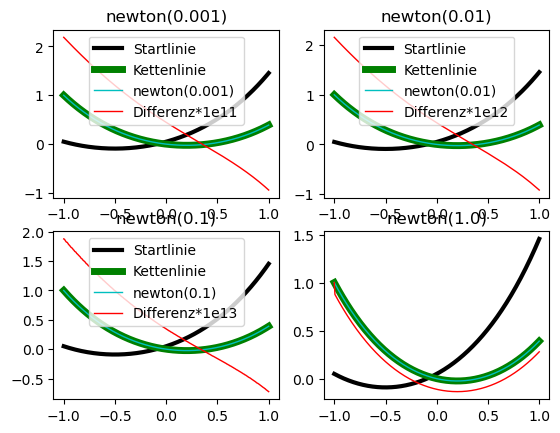

In [4]:
def g(y, PKX, PKY, PKL):
    """
    Funktion zur Bestimmung der Parameter der Kettenlinie durch die beiden
    Punkte P bzw. Q = (x_i,y_i). Deren Koordinaten befinden sich in den globalen
    Variablen PKX=(x_p,x_q) und PKY=(y_p,y_q). Die Laenge der Kettenlinie
    -ein weiterer zur Berechnung notwendiger Wert- steht in der globalen Variablen PKL.
    """
    r = np.zeros(3)
    a = y[0]
    b = y[1]
    c = y[2]
    x0 = a * (PKX[0] + b)
    x1 = a * (PKX[1] + b)
    r[0] = np.cosh(x0) / a + c - PKY[0]
    r[1] = np.cosh(x1) / a + c - PKY[1]
    r[2] = abs((np.sinh(x1) - np.sinh(x0)) / a) - PKL
    return r


def Dg(y, PKX, PKY, PKL):
    """
    Bestimmung der Jacobi-Matrix zur obigen Funktion 'g(y)'.
    Parameter und globale Variable sind mit denen in 'g' identisch.
    """
    a, b, c = y[0], y[1], y[2]
    y0, y1 = PKX[0] + b, PKX[1] + b
    x0, x1 = a * y0, a * y1
    sh0, sh1, ch0, ch1 = sinh(x0), sinh(x1), np.cosh(x0), np.cosh(x1)
    sgn = np.sign((sh1 - sh0) / a)
    M = np.array(
        [
            [(y0 * sh0 - ch0 / a) / a, sh0, 1.0],
            [(y1 * sh1 - ch1 / a) / a, sh1, 1.0],
            [
                sgn * ((y1 * ch1 - y0 * ch0 - (sh1 - sh0) / a) / a),
                sgn * (ch1 - ch0),
                0.0,
            ],
        ]
    )
    return M


#
#  Kettenlinie
#    cosh(x) := 0.5*(exp(x)+exp(-x))
#    sinh(x) := 0.5*(exp(x)-exp(-x))
#
def kette(a, b, c, x):
    return np.cosh(a * (x + b)) / a + c


def kettelen(a, b, c, x):
    return np.abs(np.sinh(a * (x[1] + b)) / a - np.sinh(a * (x[0] + b)) / a)


def jacobi_check(g, Dg, x):
    """
    Vergleiche die analytischen partiellen Ableitungen Dg(x) der Funktion g
    an der Stelle x mit den numerischen partiellen Ableitungen
    (zentrale Differenzen).
    Es resultiert die Matrix der Differenzen 'analytisch-numerisch'.
    """
    n = x.shape[0]
    dig = np.zeros((n, n))
    dix = 0.0001 * max(1.0, np.max(np.abs(x)))
    dx = Dg(x)
    for i in range(n):
        ui = x.copy()
        ui[i] -= dix
        vi = x.copy()
        vi[i] += dix
        dig[:, i] = dx[:, i] - (g(vi) - g(ui)) / (2.0 * dix)
    return dig


#
#  Betrachtet wird das Intervall PKX
#
PKX = np.array([-1.0, 1.0])
x = np.copy(PKX)
xx = np.linspace(x[0], x[1], 301)
#
#  exakte Loesung:
#
a = 1.2  # relative Breite der Intervalls
b = -0.2  # negative X-Position des cosh-Minimums
c = 1.0 - np.cosh(a * (x[0] + b)) / a  # -0.8573431565327811 ==> y_1 == 1.0
yy = kette(a, b, c, xx)
PKY = np.array([yy[0], yy[-1]])
PKL = kettelen(a, b, c, PKX)
#
#  Speicher fuer Iterationszahlen und Rechenzeiten:
#
kx = np.zeros(4)
ct = np.zeros(4)
#
#  Startwerte der Newton-Iteration
#  Es werden drei Varianten angeboten. Bei der letzten davon konvergiert
#  das gedaempfte Newton-Verfahren auch ohne Daempfung.
#  Bei der mittleren Variante gilt das nicht.
#
# ao, bo, co = 1.095, 0.55, -1.0
# ao, bo, co = 1.0, 1.0, 1.0
ao, bo, co = 1.1, 0.5, -1.0
print("Start-Koeffizienten:")
print(ao, bo, co)
oo = kette(ao, bo, co, xx)
#
#  Es wird eine Grafik mit vier Teilen aufgebaut. Die Teile zeigen die
#  Ergebnisse der Iterationen mit verschiedenen Daempfungsparametern lambda0.
#  In jedem Teilbild sind die Kettenlinie der exakten Loesung mit einer
#  dicken Linie, darauf die Linie der Naeherungsloesung mit duennerem Strich
#  und zuletzt die Kettenlinie der exakten Loesung zuzueglich des Fehlers
#  der Naeherung eingezeichnet. Dabei wird die Fehlerlinie mit einem Faktor
#  versehen, damit ihr Verlauf von dem der Naeherungslinie unterschieden
#  werden kann. Diese Faktoren sind so gewaehlt,  dass die Skalierungen der
#  Teilbilder identisch sind.
#  Den Fehler kann man zuerst in einem np.arctan-Aufruf einbetten;
#  dadurch werden kleine Fehler kaum verfaelscht (nahe 0 ist arctan
#  nahezu linear), aber grosse Fehler auf (fast) konstant 1.5
#  abgebildet, und das Vorzeichen bleibt erhalten.
#
plt.figure("Kettenlinie")
#
# lambda0 = 0.001
#
plt.subplot(2, 2, 1)
plt.title("newton(0.001)")
cut = time.perf_counter()
abc, kx[0] = newton(lambda x: g(x, PKX, PKY, PKL), lambda x: Dg(x, PKX, PKY, PKL), 0.001, np.array([ao, bo, co]), 1e-14, 1000000)
ct[0] = time.perf_counter() - cut
zz = kette(abc[0], abc[1], abc[2], xx)
plt.plot(xx, oo, "k-", linewidth=3)
plt.plot(xx, yy, "g-", linewidth=5)
plt.plot(xx, zz, "c-", linewidth=1)
# plt.plot ( xx,yy+1e11*np.arctan(yy-zz),'r-',linewidth=1 )
plt.plot(xx, yy + 1e11 * (yy - zz), "r-", linewidth=1)
plt.legend(
    ["Startlinie", "Kettenlinie", "newton(0.001)", "Differenz*1e11"], loc=9
)
#
# lambda0 = 0.01
#
plt.subplot(2, 2, 2)
plt.title("newton(0.01)")
cut = time.perf_counter()
abc, kx[1] = newton(lambda x: g(x, PKX, PKY, PKL), lambda x: Dg(x, PKX, PKY, PKL), 0.01, np.array([ao, bo, co]), 1e-14, 100000)
ct[1] = time.perf_counter() - cut
zz = kette(abc[0], abc[1], abc[2], xx)
plt.plot(xx, oo, "k-", linewidth=3)
plt.plot(xx, yy, "g-", linewidth=5)
plt.plot(xx, zz, "c-", linewidth=1)
# plt.plot ( xx,yy+1e12*np.arctan(yy-zz),'r-',linewidth=1 )
plt.plot(xx, yy + 1e12 * (yy - zz), "r-", linewidth=1)
plt.legend(
    ["Startlinie", "Kettenlinie", "newton(0.01)", "Differenz*1e12"], loc=9
)
#
# lambda0 = 0.1
#
plt.subplot(2, 2, 3)
plt.title("newton(0.1)")
cut = time.perf_counter()
abc, kx[2] = newton(lambda x: g(x, PKX, PKY, PKL), lambda x: Dg(x, PKX, PKY, PKL), 0.1, np.array([ao, bo, co]), 1e-14, 10000)
ct[2] = time.perf_counter() - cut
zz = kette(abc[0], abc[1], abc[2], xx)
plt.plot(xx, oo, "k-", linewidth=3)
plt.plot(xx, yy, "g-", linewidth=5)
plt.plot(xx, zz, "c-", linewidth=1)
# plt.plot ( xx,yy+1e13*np.arctan(yy-zz),'r-',linewidth=1 )
plt.plot(xx, yy + 1e13 * (yy - zz), "r-", linewidth=1)
plt.legend(
    ["Startlinie", "Kettenlinie", "newton(0.1)", "Differenz*1e13"], loc=9
)
#
# lambda0 = 1.0
#
plt.subplot(2, 2, 4)
plt.title("newton(1.0)")
cut = time.perf_counter()
abc, kx[3] = newton(lambda x: g(x, PKX, PKY, PKL), lambda x: Dg(x, PKX, PKY, PKL), 1.0, np.array([ao, bo, co]), 1e-14, 1000)
#
#  Das ungedaempfte Newton-Verfahren braucht mitunter einen Startwert
#  'in der Naehe' des Ziels. Daher hier ein anderer Startwert:
#
# abc,kx[3] = newton ( g,Dg,1.0,np.array([1.095, 0.55, -2.0]),1e-14,1000 )
# print ( abc )
#
#  a == 1.2,     b == -0.2,   c = -0.85734316
#  a >= 1.095,   b <= 0.55,   c relativ egal
#
ct[3] = time.perf_counter() - cut
zz = kette(abc[0], abc[1], abc[2], xx)
plt.plot(xx, oo, "k-", linewidth=3)
plt.plot(xx, yy, "g-", linewidth=5)
plt.plot(xx, zz, "c-", linewidth=1)
# print ( np.min(zz),np.max(zz) )
# print ( np.max(np.arctan(yy-zz)) )
# plt.plot ( xx,yy+1e15*np.arctan(yy-zz),'r-',linewidth=1 ) #
plt.plot(xx, yy + 1e15 * (yy - zz), "r-", linewidth=1)  #
plt.leg

#
#
#
plt.suptitle("gedämpftes Newton-Verfahren mit Toleranz 1e-14", fontsize=24)

print("Newton-lambda0:               0.001    0.01     0.1      1.0")
print(
    "Iterationsschritte:      %7d  %7d  %7d  %7d" % (kx[0], kx[1], kx[2], kx[3])
)
print(
    'Rechenzeiten["]:          %6.2f"  %6.2f"  %6.2f"  %6.2f"'
    % (ct[0], ct[1], ct[2], ct[3])
)
print('Gesamt-Rechenzeit["]:   %8.2f"' % (np.sum(ct)))
sys.stdout.flush()

plt.show()